In [152]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import copy,os

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

import seaborn as sns
sns.set()

In [153]:
df_sales = pd.read_csv('../../data/rdc_sales_1320_replenishment_V1_filled.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)
df_sl = df_sl.reset_index()

In [154]:
data_start_date = df_sl.columns[1]
data_end_date = df_sl.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2016-01-01 to 2018-08-31


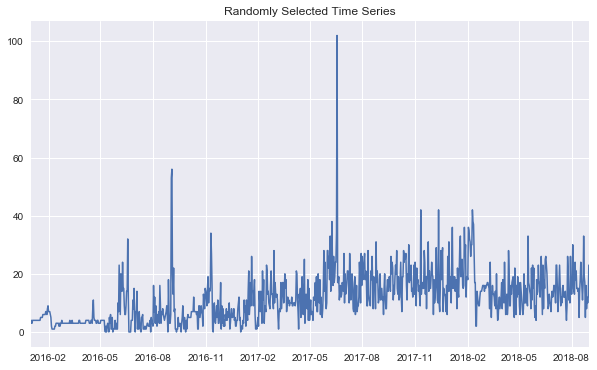

In [376]:

plt.figure(figsize=(10,6))

pd.Series(df_sl.iloc[36320,1:]).astype(np.float64).plot(linewidth=1.5)

plt.title('Randomly Selected Time Series');
    
# plot_random_series(df_sl, 1)

In [156]:
from datetime import timedelta

pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [157]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [158]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2016-01-01 00:00:00 - 2018-08-03 00:00:00
Train prediction: 2018-08-04 00:00:00 - 2018-08-17 00:00:00 

Val encoding: 2016-01-15 00:00:00 - 2018-08-17 00:00:00
Val prediction: 2018-08-18 00:00:00 - 2018-08-31 00:00:00

Encoding interval: 946
Prediction interval: 14


In [159]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df_sl.columns[1:]]),
                          data=[i for i in range(len(df_sl.columns[1:]))])

series_array = df_sl[df_sl.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
#     series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
#     series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [160]:
first_n_samples = 40000
batch_size = 2**11
epochs = 50

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

In [270]:
## Parameters
learning_rate = 0.005
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 56
# length of output signals
output_seq_len = 14
# size of LSTM Cell
hidden_dim = 100 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph():
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        scope=None):

            with variable_scope.variable_scope(scope or "rnn_decoder"):
                state = initial_state
                outputs = []
                prev = None
                for i, inp in enumerate(decoder_inputs):
                    if i > 0:
                        variable_scope.get_variable_scope().reuse_variables()
                    output, state = cell(inp, state)
                    outputs.append(output)
            return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              dtype=dtypes.float32,
                              scope=None):

            with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
                enc_cell = copy.deepcopy(cell)
                _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
                return _rnn_decoder(decoder_inputs, enc_state, cell)
    
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(1*tf.clip_by_value(_y - _Y, 0, np.inf)+9*tf.clip_by_value(_Y-_y, 0, np.inf))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss
        print(1)

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        print(2)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

In [271]:
total_iteractions = 10
batch_size = 200
KEEP_RATE = 0.5
train_losses = []
val_losses = []

tf.reset_default_graph()
rnn_model = build_graph()
print('Build done.')
saver = tf.train.Saver()

1
2
Build done.


In [272]:
init = tf.global_variables_initializer()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        loss = 0
        for bs in range(first_n_samples//batch_size):
            idx = np.random.randint(first_n_samples//batch_size) * batch_size
            feed_dict = {rnn_model['enc_inp'][t]: 
                         encoder_input_data[idx:idx+batch_size,t+enc_length.days-input_seq_len,:] for t in range(input_seq_len)}
            feed_dict.update({rnn_model['target_seq'][t]: 
                              decoder_target_data[idx:idx+batch_size,t,:] for t in range(output_seq_len)})
            _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
            loss += loss_t*batch_size
        print(loss/first_n_samples)
    
    path = os.path.join('./../logs/temp', 'univariate_ts_model1')
    if not tf.gfile.Exists(path):
        tf.gfile.MakeDirs(path)
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, path)
        
print("Checkpoint saved at: ", save_path)

10.978736193180085
8.303143109679223
7.380231900811196
6.900825420022011
6.9033672112226485
6.735150385499001
6.47386454463005
7.056275917887688
6.684391319155693
6.826124543845654
Checkpoint saved at:  ./../logs/temp/univariate_ts_model1


In [335]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end) 
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [340]:
test_idx = 16330 #三只松鼠

test_seq_input = encoder_input_data[test_idx,:,:]
test_seq_target = decoder_target_data[test_idx,:,:]

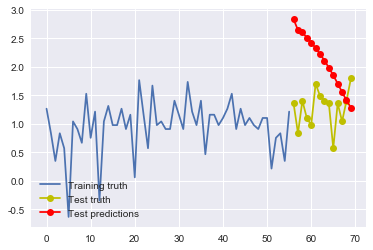

In [343]:
# rnn_model = build_graph()
# init = tf.global_variables_initializer()
REF_TIME = enc_length.days
PRED_LEN = output_seq_len
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./../logs/temp/', 'univariate_ts_model1'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[REF_TIME-input_seq_len+t].reshape(1,1) 
                 for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

    np.exp(final_preds + encode_series_mean[test_idx])-1
l1, = plt.plot(range(input_seq_len), test_seq_input[REF_TIME-input_seq_len:], label = 'Training truth')
l2, = plt.plot(range(input_seq_len, input_seq_len+14), test_seq_target.reshape(-1), 'y-o', label = 'Test truth')
l3, = plt.plot(range(input_seq_len, input_seq_len+14), 2*final_preds[0], 'r-o', label = 'Test predictions')
plt.legend(handles = [l1, l2, l3], loc = 'lower left')
plt.show()

## Synthetic Simulation (MQRNN)

In [345]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_pred_end) 
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [402]:
# index 101350, SKU 6450270#10, 茂德公 辣酱3口味
# index 16330, SKU 1552841#3, 安琪低糖高活性干酵母
# index 36320, SKU 2615317#6, 海底捞 精品水煮鱼
test_idx = 16330

test_seq_input = encoder_input_data[test_idx,:,:]
test_seq_target = decoder_target_data[test_idx,:,:]

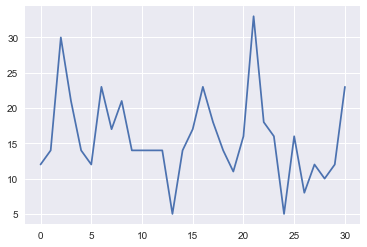

In [403]:
simu_start_date = dt.datetime(2018,8,1) - val_enc_start
np.random.seed(0)
h = 1
b = 9
simu_start_date = (dt.datetime(2018,8,1) - val_enc_start).days
end_of_horizon = 31
demand = np.exp(test_seq_input[simu_start_date:] + encode_series_mean[test_idx])-1
demand = np.array([int(i) for i in demand])
plt.plot(demand)

## Inventory simulator

In [404]:
def countOccurrences(arr, x):
    res = 0
    for i in range(len(arr)):
        if x == arr[i]:
            res += 1
    return res

In [405]:
import pickle

#sku: 6450270#10
'''N = 6
order_time = [0, 5, 7, 12, 14, 19]
arrive_time = [2, 7, 10, 16, 16, 23]
VLT = [2, 2, 3, 4, 2, 4]
VLT_pred = [3, 3, 3, 3, 3, 3]
e2e = [112, 80, 95, 76, 106, 88] #end2end order qtty
bm1 = [49, 44, 41, 46, 50, 53] #benchmark1 90% quantile prediction'''

#sku: 1552841#3
'''N = 3
order_time = [0, 7, 19]
arrive_time = [6, 15, 28]
VLT = [6, 8, 9]
VLT_pred = [8, 8, 8]
e2e = [275, 387, 175] #end2end order qtty
bm1 = [74, 77, 68]'''

#sku: 2615317#6
N = 2
order_time = [5, 12]
arrive_time = [13, 19]
VLT = [8, 7]
VLT_pred = [6, 6]
e2e = [260, 266] #end2end order qtty
bm1 = [79, 81]
with open('pred_E2E_NN_RNN_2615317#6.pkl', 'rb') as fp: #benchmark2 qunatile prediction
    sf = pickle.load(fp)

In [412]:
with open('pred_E2E_SF_RNN.pkl', 'rb') as fp: #benchmark2 qunatile prediction
    sf = pickle.load(fp)

In [414]:
sf

array([[[ 1.00055344e+02,  1.38031235e+02,  1.72243134e+02, ...,
          2.30383621e+02,  2.74279236e+02,  3.28076721e+02],
        [ 9.95615768e+01,  1.37505707e+02,  1.70395020e+02, ...,
          2.24151779e+02,  2.64660370e+02,  3.16805878e+02],
        [ 9.70737305e+01,  1.34076126e+02,  1.65868820e+02, ...,
          2.17463638e+02,  2.56219086e+02,  3.06759216e+02],
        ...,
        [ 8.81619339e+01,  1.21373970e+02,  1.57316650e+02, ...,
          2.16824539e+02,  2.62904236e+02,  3.19330383e+02],
        [ 8.85597458e+01,  1.21951035e+02,  1.57715668e+02, ...,
          2.16637451e+02,  2.62284088e+02,  3.18371063e+02],
        [ 8.74113922e+01,  1.20286415e+02,  1.56075623e+02, ...,
          2.14932877e+02,  2.60516724e+02,  3.16687408e+02]],

       [[ 9.83726501e+01,  1.36370453e+02,  1.70565918e+02, ...,
          2.28183853e+02,  2.72202759e+02,  3.26474121e+02],
        [ 9.58326950e+01,  1.32705154e+02,  1.64130524e+02, ...,
          2.16235992e+02,  2.55221893e

In [409]:
history_inv_e2e = []
order_list_e2e = []
h_cost_list_e2e = []
b_cost_list_e2e = []
cost_list_e2e = []

history_inv_bm1 = []
order_list_bm1 = []
h_cost_list_bm1 = []
b_cost_list_bm1 = []
cost_list_bm1 = []

history_inv_bm2 = []
order_list_bm2 = []
h_cost_list_bm2 = []
b_cost_list_bm2 = []
cost_list_bm2 = []

inv0 = int(np.sum(demand[0:VLT[0]]))
inv_e2e = inv0
inv_bm1 = inv0
inv_bm2 = inv0
print('Initial Inventory:', inv0)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(init)
    saver = rnn_model['saver']().restore(sess, os.path.join('./../logs/temp/', 'univariate_ts_model0'))
    
    # simulate the inventory change
    for t in range(order_time[0], end_of_horizon):
        if t in arrive_time:
            occurance = countOccurrences(arrive_time, t)
            while(occurance>0):
                i = arrive_time.index(t)+occurance-1
                print('receiving ',i , 'th order at time', t, 'Order qtty e2e:', order_list_e2e[i], 
                      'Order qtty benchmark1:', order_list_bm1[i], 'Order qtty benchmark1:', order_list_bm2[i])
                inv_e2e = inv_e2e + order_list_e2e[i]
                inv_bm1 = inv_bm1 + order_list_bm1[i]
                inv_bm2 = inv_bm2 + order_list_bm2[i]
                occurance = occurance-1
        
        if t in order_time:
            '''feed_dict = {rnn_model['enc_inp'][j]: 
                         test_seq_input[simu_start_date+t-input_seq_len+j].reshape(1,1) for j in range(input_seq_len)}
            
            feed_dict.update({rnn_model['target_seq'][j]: np.zeros([1, output_dim]) for j in range(output_seq_len)})
            
            final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
            
            # forecast the sales in next 14 days
            sales_14d_pred = np.exp(final_preds + encode_series_mean[test_idx])-1
            #print('Sales forecast:', np.array(sales_14d_pred).reshape(14, 1))'''
            
            # current order time
            cur_order_index = order_time.index(t)
            
            # predicted current order arrive time
            #cur_order_arrive = t + VLT_pred[cur_order_index]
            cur_order_arrive = t 
            
            # predicted next order arrive time 
            next_order_arrive = t + R + np.mean(VLT)
            
            # number of days between the current order arrive and next order arrive; 
            days = int(next_order_arrive - cur_order_arrive)
            
            #print('current order arrive:', cur_order_arrive, 'Next order arrive:', next_order_arrive, 'days:', days)
            
            #order_qtty = 2*int(np.sum(sales_14d_pred[cur_order_arrive-t:cur_order_arrive+days-t]))
            
            #benchmark1
            sf_mean = bm1[cur_order_index]-50
            order_qtty1 = int(sf_mean*days)-inv_bm1
            order_qtty1 = np.max([order_qtty1, 0])
            order_list_bm1.append(order_qtty1)
            
            #benchmark2
            # the optimal DP order qtty is the sales sum of [cur_order_arrive: cur_order_arrive+(b/b+h)*days]
            days_bm2 = int(days*(b*1.0/(b+h)))
            sf_mqrnn = sf[cur_order_index]
            order_qtty2 = int(np.sum(sf[cur_order_index][:, 6][cur_order_arrive-t:cur_order_arrive+days_bm2-t]))-inv_bm2
            order_qtty2 = np.max([order_qtty2, 0])
            order_list_bm2.append(order_qtty2)
            
            #end2end
            order_qtty0 = int(e2e[cur_order_index])-inv_e2e
            order_qtty0 = np.max([order_qtty0, 0])
            order_list_e2e.append(order_qtty0)
            
            print('placing ', cur_order_index, 'th order at time', t, 'Order qtty e2e:', order_qtty0,
                 'Order qtty benchmark1:', order_qtty1, 'Order qtty benchmark1:', order_qtty2)
        
        inv_e2e = inv_e2e - demand[t]
        inv_bm1 = inv_bm1 - demand[t]
        inv_bm2 = inv_bm2 - demand[t]
        
        #e2e
        h_cost_e2e = h*np.maximum(0, inv_e2e)
        b_cost_e2e = b*np.maximum(0, -inv_e2e)
        h_cost_list_e2e.append(h_cost_e2e)
        b_cost_list_e2e.append(b_cost_e2e)
        cost_list_e2e.append(h_cost_e2e+b_cost_e2e)
        
        #benchmark1
        h_cost_bm1 = h*np.maximum(0, inv_bm1)
        b_cost_bm1 = b*np.maximum(0, -inv_bm1)
        h_cost_list_bm1.append(h_cost_bm1)
        b_cost_list_bm1.append(b_cost_bm1)
        cost_list_bm1.append(h_cost_bm1+b_cost_bm1)
        
        #benchmark2
        h_cost_bm2 = h*np.maximum(0, inv_bm2)
        b_cost_bm2 = b*np.maximum(0, -inv_bm2)
        h_cost_list_bm2.append(h_cost_bm2)
        b_cost_list_bm2.append(b_cost_bm2)
        cost_list_bm2.append(h_cost_bm2+b_cost_bm2)
        
        history_inv_e2e.append(inv_e2e)
        history_inv_bm1.append(inv_bm1)      
        history_inv_bm2.append(inv_bm2)

Initial Inventory: 143
placing  0 th order at time 5 Order qtty e2e: 117 Order qtty benchmark1: 263 Order qtty benchmark1: 214
placing  1 th order at time 12 Order qtty e2e: 238 Order qtty benchmark1: 406 Order qtty benchmark1: 344
receiving  0 th order at time 13 Order qtty e2e: 117 Order qtty benchmark1: 263 Order qtty benchmark1: 214
receiving  1 th order at time 19 Order qtty e2e: 238 Order qtty benchmark1: 406 Order qtty benchmark1: 344


Text(0.5,1,'SKU: 2615317#6')

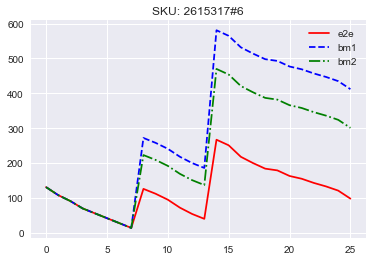

In [411]:
plt.figure
plt.plot(history_inv_e2e, 'r-', label = 'e2e')
plt.plot(history_inv_bm1, 'b--', label = 'bm1')
plt.plot(history_inv_bm2, 'g-.', label = 'bm2')
plt.legend()
plt.title('SKU: 2615317#6')

In [408]:
print('End 2 end cost:', np.sum(cost_list_e2e))
print('Benchmark1 cost:', np.sum(cost_list_bm1))
print('Benchmark2 cost:', np.sum(cost_list_bm2))

End 2 end cost: 3151
Benchmark1 cost: 11995
Benchmark2 cost: 6169


## Synthetic Simulation (seq2seq)

In [307]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_pred_end) 
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [320]:
# index 101350, SKU 6450270#10, 茂德公 辣酱3口味
# index 16330, SKU 1552841#3, 安琪低糖高活性干酵母
# index 36320, SKU 2615317#6, 海底捞 精品水煮鱼
test_idx = 16330 #16330 ()

test_seq_input = encoder_input_data[test_idx,:,:]
test_seq_target = decoder_target_data[test_idx,:,:]

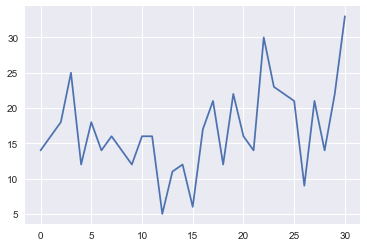

In [321]:
simu_start_date = dt.datetime(2018,8,1) - val_enc_start
np.random.seed(0)
h = 1
b = 9
simu_start_date = (dt.datetime(2018,8,1) - val_enc_start).days
end_of_horizon = 31
demand = np.exp(test_seq_input[simu_start_date:] + encode_series_mean[test_idx])-1
demand = np.array([int(i) for i in demand])
plt.plot(demand)

In [328]:
#sku: 6450270#10
'''N = 6
order_time = [0, 5, 7, 12, 14, 19]
arrive_time = [2, 7, 10, 16, 16, 23]
VLT = [2, 2, 3, 4, 2, 4]
VLT_pred = [3, 3, 3, 3, 3, 3]
e2e = [112, 80, 95, 76, 106, 88] #end2end order qtty
bm1 = [49, 44, 41, 46, 50, 53] #benchmark1 90% quantile prediction
with open('pred_E2E_NN_RNN.pkl', 'rb') as fp: #benchmark2 qunatile prediction
    sf = pickle.load(fp)'''

#sku: 1552841#3
'''N = 3
order_time = [0, 7, 19]
arrive_time = [6, 15, 28]
VLT = [6, 8, 9]
VLT_pred = [8, 8, 8]
e2e = [275, 387, 175] #end2end order qtty'''

#sku: 2615317#6
N = 2
order_time = [5, 12]
arrive_time = [13, 19]
VLT = [8, 7]
VLT_pred = [6, 6]
e2e = [260, 266] #end2end order qtty

In [329]:
history_inv_e2e = []
order_list_e2e = []
h_cost_list_e2e = []
b_cost_list_e2e = []
cost_list_e2e = []

history_inv_bm1 = []
order_list_bm1 = []
h_cost_list_bm1 = []
b_cost_list_bm1 = []
cost_list_bm1 = []

history_inv_bm2 = []
order_list_bm2 = []
h_cost_list_bm2 = []
b_cost_list_bm2 = []
cost_list_bm2 = []

inv0 = int(np.sum(demand[0:VLT[0]]))
inv_e2e = inv0
inv_bm1 = inv0
inv_bm2 = inv0
print('Initial Inventory:', inv0)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(init)
    saver = rnn_model['saver']().restore(sess, os.path.join('./../logs/temp/', 'univariate_ts_model1'))
    
    # simulate the inventory change
    for t in range(order_time[0], end_of_horizon):
        if t in arrive_time:
            occurance = countOccurrences(arrive_time, t)
            while(occurance>0):
                i = arrive_time.index(t)+occurance-1
                print('receiving ',i , 'th order at time', t, 'Order qtty e2e:', order_list_e2e[i], 
                      'Order qtty benchmark1:', order_list_bm1[i], 'Order qtty benchmark1:', order_list_bm2[i])
                inv_e2e = inv_e2e + order_list_e2e[i]
                inv_bm1 = inv_bm1 + order_list_bm1[i]
                inv_bm2 = inv_bm2 + order_list_bm2[i]
                occurance = occurance-1
        
        if t in order_time:
            feed_dict = {rnn_model['enc_inp'][j]: 
                         test_seq_input[simu_start_date+t-input_seq_len+j].reshape(1,1) for j in range(input_seq_len)}
            
            feed_dict.update({rnn_model['target_seq'][j]: np.zeros([1, output_dim]) for j in range(output_seq_len)})
            
            final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
            
            # forecast the sales in next 14 days
            sales_14d_pred = np.exp(final_preds + encode_series_mean[test_idx])-1
            sales_14d_pred = np.array([np.ceil(i) for i in sales_14d_pred]).reshape(14, 1)
            #print('Sales forecast:', np.array(sales_14d_pred).reshape(14, 1))'''
            
            # current order time
            cur_order_index = order_time.index(t)
            
            # predicted current order arrive time
            cur_order_arrive = t + VLT_pred[cur_order_index]
            
            # predicted next order arrive time 
            next_order_arrive = t + R + np.mean(VLT)
            
            # number of days between the current order arrive and next order arrive; 
            days = int(next_order_arrive - cur_order_arrive)
            
            #print('current order arrive:', cur_order_arrive, 'Next order arrive:', next_order_arrive, 'days:', days)
            
            #order_qtty = 2*int(np.sum(sales_14d_pred[cur_order_arrive-t:cur_order_arrive+days-t]))
            
            #benchmark1
            sf_mean = np.mean(sales_14d_pred)
            order_qtty1 = int(sf_mean*days)
            order_qtty1 = np.max([order_qtty1, 0])
            order_list_bm1.append(order_qtty1)
            
            #benchmark2
            # the optimal DP order qtty is the sales sum of [cur_order_arrive: cur_order_arrive+(b/b+h)*days]
            days_bm2 = int(days*(b*1.0/(b+h)))
            order_qtty2 = int(np.sum(sales_14d_pred[cur_order_arrive-t:cur_order_arrive+days_bm2-t]))
            order_qtty2 = np.max([order_qtty2, 0])
            order_list_bm2.append(order_qtty2)
            
            #end2end
            order_qtty0 = int(e2e[cur_order_index])-inv_e2e
            order_qtty0 = np.max([order_qtty0, 0])
            order_list_e2e.append(order_qtty0)
            
            print('placing ', cur_order_index, 'th order at time', t, 'Order qtty e2e:', order_qtty0,
                 'Order qtty benchmark1:', order_qtty1, 'Order qtty benchmark1:', order_qtty2)
        
        inv_e2e = inv_e2e - demand[t]
        inv_bm1 = inv_bm1 - demand[t]
        inv_bm2 = inv_bm2 - demand[t]
        
        #e2e
        h_cost_e2e = h*np.maximum(0, inv_e2e)
        b_cost_e2e = b*np.maximum(0, -inv_e2e)
        h_cost_list_e2e.append(h_cost_e2e)
        b_cost_list_e2e.append(b_cost_e2e)
        cost_list_e2e.append(h_cost_e2e+b_cost_e2e)
        
        #benchmark1
        h_cost_bm1 = h*np.maximum(0, inv_bm1)
        b_cost_bm1 = b*np.maximum(0, -inv_bm1)
        h_cost_list_bm1.append(h_cost_bm1)
        b_cost_list_bm1.append(b_cost_bm1)
        cost_list_bm1.append(h_cost_bm1+b_cost_bm1)
        
        #benchmark2
        h_cost_bm2 = h*np.maximum(0, inv_bm2)
        b_cost_bm2 = b*np.maximum(0, -inv_bm2)
        h_cost_list_bm2.append(h_cost_bm2)
        b_cost_list_bm2.append(b_cost_bm2)
        cost_list_bm2.append(h_cost_bm2+b_cost_bm2)
        
        history_inv_e2e.append(inv_e2e)
        history_inv_bm1.append(inv_bm1)      
        history_inv_bm2.append(inv_bm2)

Initial Inventory: 133
placing  0 th order at time 5 Order qtty e2e: 127 Order qtty benchmark1: 156 Order qtty benchmark1: 120
placing  1 th order at time 12 Order qtty e2e: 239 Order qtty benchmark1: 140 Order qtty benchmark1: 105
receiving  0 th order at time 13 Order qtty e2e: 127 Order qtty benchmark1: 156 Order qtty benchmark1: 120
receiving  1 th order at time 19 Order qtty e2e: 239 Order qtty benchmark1: 140 Order qtty benchmark1: 105


Text(0.5,1,'SKU: 2615317#6')

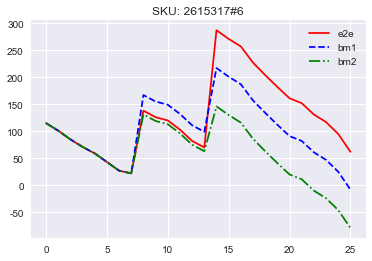

In [332]:
plt.figure
plt.plot(history_inv_e2e, 'r-', label = 'e2e')
plt.plot(history_inv_bm1, 'b--', label = 'bm1')
plt.plot(history_inv_bm2, 'g-.', label = 'bm2')
plt.legend()
plt.title('SKU: 2615317#6')

In [333]:
print('End 2 end cost:', np.sum(cost_list_e2e))
print('Benchmark1 cost:', np.sum(cost_list_bm1))
print('Benchmark2 cost:', np.sum(cost_list_bm2))

End 2 end cost: 3308
Benchmark1 cost: 2722
Benchmark2 cost: 3164
